In [5]:
# class 0에서 랜덤하게 1100개를 선택해서 사용 
import csv
import numpy as np
import copy
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori

In [6]:
with open('data/dataset.csv', 'r') as file:
        data_set = [list(filter(None, row)) for row in csv.reader(file)]
        
print(len(data_set))

4615


In [7]:
te = TransactionEncoder()
te_ary = te.fit_transform(data_set)
m_transactions = pd.DataFrame(te_ary, columns=te.columns_)

print(m_transactions.shape)

(4615, 149)


In [8]:
transactions_0 = pd.DataFrame(
            m_transactions[m_transactions['0']].reset_index(drop=True).drop(['1', '0'], axis=1))
transactions_1 = pd.DataFrame(
            m_transactions[m_transactions['1']].reset_index(drop=True).drop(['1', '0'], axis=1))


In [9]:
random.seed(10)
indices = list( range(0, len(transactions_0)) )
random.shuffle(indices)
transactions_te_0 = transactions_0.iloc[indices[:417],:]
#transactions_tr_00 = transactions_0.iloc[indices[417:810],:]
transactions_tr_0 = transactions_0.iloc[indices[417:],:]

indices = list( range(0, len(transactions_1)) )
random.shuffle(indices)
transactions_te_1 = transactions_1.iloc[indices[:43],:]
transactions_tr_1 = transactions_1.iloc[indices[43:],:]

tr_0_ary=(transactions_tr_0.values).astype('int')
tr_1_ary=(transactions_tr_1.values).astype('int')

#tr_00_ary=(transactions_tr_00.values).astype('int')

transactions_tr = pd.concat([transactions_tr_0, transactions_tr_1])

In [10]:
frequent_items = apriori(transactions_tr, min_support=0.1)
print(transactions_tr.shape, len(frequent_items))

(4155, 147) 22554


In [11]:
natt = transactions_tr.shape[1]  #number of attributes 
nf = len(frequent_items)   #number of frequent items 
a = frequent_items['itemsets']
b = [list(x) for x in a]
c= np.zeros((natt,nf))
for i in range(len(frequent_items)):
    c[b[i],i]=1

In [12]:
#1-ccs/cls
newc = copy.deepcopy(c)
x_00 = np.matmul(tr_0_ary, c)
x_01 = np.matmul(tr_1_ary, c)

item_len = np.sum(c, axis=0) #item length
cls0 = np.zeros(nf)   #frequent_items['support']
cls1 = np.zeros(nf) 
p = np.zeros(nf)
conf = np.zeros(nf)
indc = np.zeros(nf, dtype=int) 
cnt=0
for i in range(x_00.shape[1]):
    cls0[i] = (x_00[:,i]>=item_len[i]).sum()/x_00.shape[0]
    cls1[i] = (x_01[:,i]>=item_len[i]).sum()/x_01.shape[0]
    p[i] = ((x_00[:,i]>=item_len[i]).sum()+ (x_01[:,i]>=item_len[i]).sum())/(x_00.shape[0]+x_01.shape[0])
    if cls1[i]/cls0[i]<1:
        indc[i] = 0
        conf[i] = 1- cls1[i]/cls0[i]
        cnt = cnt +1
    elif cls1[i]/cls0[i]>1:
        indc[i] = 1
        conf[i] = 1- cls0[i]/cls1[i]
        cnt = cnt +1
    else:
        conf[i]=0
        newc[:,i]=0
        indc[i] =-1
print('class rules', cnt)


class rules 22554


In [13]:
from sklearn.metrics import roc_auc_score

print((indc==0).sum(), (indc==1).sum())
print(conf[indc==0].mean(), conf[indc==1].mean())

te_0_ary=(transactions_te_0.values).astype('int')
te_1_ary=(transactions_te_1.values).astype('int')

#first rule used
y_0 = np.matmul(te_0_ary, newc)
y_1 = np.matmul(te_1_ary, newc)

pred = np.zeros((y_0.shape[0]+y_1.shape[0],2))
cnt0=0
cnt1=0
for i in range(y_0.shape[0]):
    maxp=-1
    for j in range(y_0.shape[1]):
        if (indc[j]==0 and y_0[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
    if (maxp==-1):
        cnt0 = cnt0+1    
    else: 
        pred[i,0] = maxp
        
    maxp=-1
    for j in range(y_0.shape[1]):
        if (indc[j]==1 and y_0[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
           
    if (maxp==-1):
        cnt1 = cnt1+1    
    else: 
        pred[i,1] = maxp
print(y_0.shape[0],cnt0, cnt1)

cnt0=0
cnt1=0
for i in range(y_1.shape[0]):
    maxp=-1
    for j in range(y_1.shape[1]):
        if (indc[j]==0 and y_1[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
    if (maxp==-1):
        cnt0 = cnt0+1    
    else: 
        pred[i+y_0.shape[0],0] = maxp
        
    maxp=-1
    for j in range(y_1.shape[1]):
        if (indc[j]==1 and y_1[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
           
    if (maxp==-1):
        cnt1 = cnt1+1    
    else: 
        pred[i+y_0.shape[0],1] = maxp
        
print(y_1.shape[0],cnt0, cnt1)

y = np.concatenate((np.zeros(te_0_ary.shape[0]), np.ones(te_1_ary.shape[0])), axis=0)
auc = roc_auc_score(y,pred[:,1])
print(auc)
y = np.concatenate((np.zeros(te_0_ary.shape[0]), np.ones(te_1_ary.shape[0])), axis=0)
auc = roc_auc_score(y,-pred[:,0])
print(auc)

15179 7375
0.5016779539597047 0.31930184734930256
417 3 3
43 3 0
0.856198761920696
0.7621158886844013


In [14]:
from sklearn.metrics import f1_score

#first rule used for training data
y_00 = np.matmul(tr_0_ary, newc)
y_01 = np.matmul(tr_1_ary, newc)

pred_tr = np.zeros((y_00.shape[0]+y_01.shape[0],2))
cnt0=0
cnt1=0
for i in range(y_00.shape[0]):
    maxp=-1
    for j in range(y_00.shape[1]):
        if (indc[j]==0 and y_00[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
           
    if (maxp==-1):
        cnt1 = cnt1+1    
    else: 
        pred_tr[i,0] = maxp
        
    maxp=-1
    for j in range(y_00.shape[1]):
        if (indc[j]==1 and y_00[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
           
    if (maxp==-1):
        cnt1 = cnt1+1    
    else: 
        pred_tr[i,1] = maxp
print(y_00.shape[0],cnt0, cnt1)

cnt0=0
cnt1=0
for i in range(y_01.shape[0]):
    maxp=-1
    for j in range(y_01.shape[1]):
        if (indc[j]==0 and y_01[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
           
    if (maxp==-1):
        cnt1 = cnt1+1    
    else: 
        pred_tr[i+y_00.shape[0],0] = maxp
        
    maxp=-1
    for j in range(y_01.shape[1]):
        if (indc[j]==1 and y_01[i,j]>=item_len[j]):
            maxp = max(maxp, conf[j])
           
    if (maxp==-1):
        cnt1 = cnt1+1    
    else: 
        pred_tr[i+y_00.shape[0],1] = maxp
        
print(y_01.shape[0],cnt0, cnt1)

y0 = np.concatenate((np.zeros(tr_0_ary.shape[0]), np.ones(tr_1_ary.shape[0])), axis=0)

z_1 = pred_tr[y0==1,1]
m = np.mean(z_1)
s = np.std(z_1)
th = m

pred_y = np.zeros(pred.shape[0], dtype=int)
for i in range(pred.shape[0]):
    if (pred[i,1]>=th):
        pred_y[i]=1

print(f1_score(y,pred_y))  

TP=0
FP=0
FN=0
TN=0
for i in range(pred.shape[0]):
    if (y[i]==1 and pred_y[i]==1):
        TP = TP+1
    elif (y[i]==1 and pred_y[i]==0):
        FN = FN+1
    elif (y[i]==0 and pred_y[i]==1):
        FP = FP+1
    else:
        TN = TN+1 

print('TP:', TP, 'FN:', FN)
print('FP:', FP, 'TN:', TN)
print('pre:', TP/(TP+FP), 'rec:', TP/(TP+FN))
print('f1:', (2*TP)/(2*TP + FP + FN))

3762 0 58
393 0 18
0.42168674698795183
TP: 35 FN: 8
FP: 88 TN: 329
pre: 0.2845528455284553 rec: 0.813953488372093
f1: 0.42168674698795183


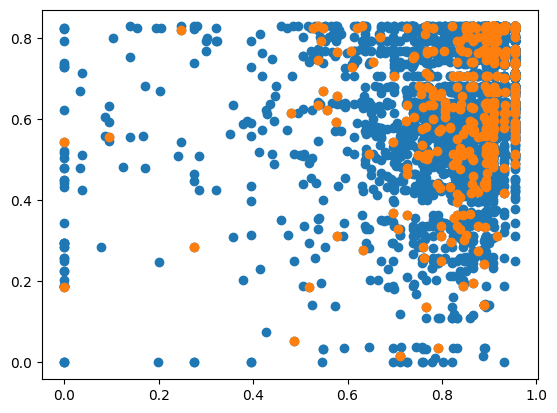

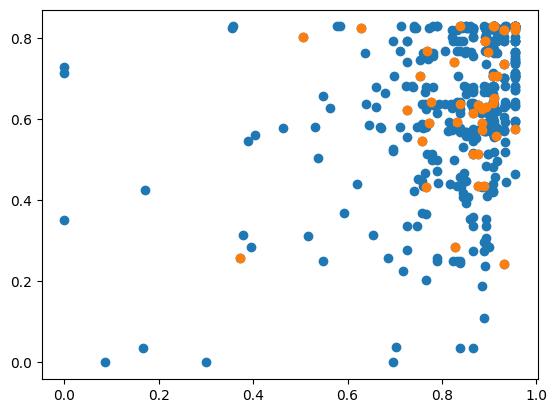

In [20]:
from matplotlib import pyplot as plt

plt.scatter(pred_tr[:tr_0_ary.shape[0],0], pred_tr[:tr_0_ary.shape[0],1])
plt.scatter(pred_tr[:tr_1_ary.shape[0],0], pred_tr[:tr_1_ary.shape[0],1])
plt.show()

plt.scatter(pred[:te_0_ary.shape[0],0], pred[:te_0_ary.shape[0],1])
plt.scatter(pred[:te_1_ary.shape[0],0], pred[:te_1_ary.shape[0],1])
plt.show()


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

n_folds = 10
tuned_parameters = [{"activation": ["relu"], "hidden_layer_sizes": [[128,64,16]]}]
#tuned_parameters = [{"activation": ("relu", "logistic", "tanh"), "hidden_layer_sizes": [[64,16],[128,64,16]]}]

mlp = MLPClassifier(learning_rate_init=0.01, max_iter=200, random_state=0)
clf = GridSearchCV(mlp, tuned_parameters, cv=n_folds, scoring='f1')
a = y0
b = pred_tr
clf.fit(np.concatenate((tr_0_ary,tr_1_ary),axis=0), y0)

print(clf.best_params_)

# pred_y = clf.predict_proba(np.concatenate((te_0_ary,te_1_ary),axis=0))
print(roc_auc_score(y,pred_tr[:,1]))
# pred_y = clf.predict(np.concatenate((te_0_ary,te_1_ary),axis=0))
print(f1_score(y,pred_tr))
TP=0
FP=0
FN=0
TN=0
for i in range(pred_y.shape[0]):
    if (y[i]==1 and pred_y[i]==1):
        TP = TP+1
    elif (y[i]==1 and pred_y[i]==0):
        FN = FN+1
    elif (y[i]==0 and pred_y[i]==1):
        FP = FP+1
    else:
        TN = TN+1 

print('TP:', TP, 'FN:', FN)
print('FP:', FP, 'TN:', TN)
print('pre:', TP/(TP+FP), 'rec:', TP/(TP+FN))
print('f1:', (2*TP)/(2*TP + FP + FN))

{'activation': 'relu', 'hidden_layer_sizes': [128, 64, 16]}


KeyboardInterrupt: 

In [14]:
#lift
newc = copy.deepcopy(c)
x_00 = np.matmul(tr_0_ary, c)
x_01 = np.matmul(tr_1_ary, c)

item_len = np.sum(c, axis=0) #item length
cls0 = np.zeros(nf)   #frequent_items['support']
cls1 = np.zeros(nf) 
p = np.zeros(nf)
conf = np.zeros(nf)
indc = np.zeros(nf, dtype=int) 
cnt=0
for i in range(x_00.shape[1]):
    cls0[i] = (x_00[:,i]>=item_len[i]).sum()/x_00.shape[0]
    cls1[i] = (x_01[:,i]>=item_len[i]).sum()/x_01.shape[0]
    p[i] = ((x_00[:,i]>=item_len[i]).sum()+ (x_01[:,i]>=item_len[i]).sum())/(x_00.shape[0]+x_01.shape[0])
    if cls0[i]/p[i]>1:
        indc[i] = 0
        conf[i] = cls0[i]/p[i]
        cnt = cnt +1
    elif cls0[i]/p[i]<1 and cls1[i]/p[i]>1:
        indc[i] = 1
        conf[i] = cls1[i]/p[i]
        cnt = cnt +1
    else:
        conf[i]=0
        newc[:,i]=0
        indc[i] =-1
print('class rules', cnt)



class rules 22554


In [15]:
from sklearn.metrics import roc_auc_score

print((indc==0).sum(), (indc==1).sum())
print(conf[indc==0].mean(), conf[indc==1].mean())

te_0_ary=(transactions_te_0.values).astype('int')
te_1_ary=(transactions_te_1.values).astype('int')

#all matched rules  used
y_0 = np.matmul(te_0_ary, newc)
y_1 = np.matmul(te_1_ary, newc)

pred = np.zeros((y_0.shape[0]+y_1.shape[0],2))
cnt0=0
cnt1=0
        
for i in range(y_0.shape[0]):
    cnt=0
    for j in range(y_0.shape[1]):
        if (indc[j]==0 and y_0[i,j]>=item_len[j]):
            pred[i,0] = pred[i,0] + conf[j]
            cnt = cnt+1
    if (cnt==0):
        cnt0 = cnt0+1    
    else: 
        pred[i,0] = pred[i,0]/cnt
        
    cnt=0
    for j in range(y_0.shape[1]):
        if (indc[j]==1 and y_0[i,j]>=item_len[j]):
            pred[i,1] = pred[i,1] + conf[j]
            cnt = cnt+1
           
    if (cnt==0):
        cnt1 = cnt1+1    
    else: 
        pred[i,1] = pred[i,1]/cnt
print(y_0.shape[0],cnt0, cnt1)

cnt0=0
cnt1=0
for i in range(y_1.shape[0]):
    cnt=0
    x=0
    for j in range(y_1.shape[1]):
        if (indc[j]==0 and y_1[i,j]>=item_len[j]):
            x = x + conf[j]
            cnt = cnt+1
    if (cnt==0):
        cnt0 = cnt0+1    
    else: 
        pred[i+y_0.shape[0],0] = x/cnt
        
    cnt=0
    x=0
    for j in range(y_1.shape[1]):
        if (indc[j]==1 and y_1[i,j]>=item_len[j]):
            x = x + conf[j]
            cnt = cnt+1
           
    if (cnt==0):
        cnt1 = cnt1+1    
    else: 
        pred[i+y_0.shape[0],1] = x/cnt
        
print(y_1.shape[0],cnt0, cnt1)

y = np.concatenate((np.zeros(te_0_ary.shape[0]), np.ones(te_1_ary.shape[0])), axis=0)
auc = roc_auc_score(y,pred[:,1])
print(auc)
y = np.concatenate((np.zeros(te_0_ary.shape[0]), np.ones(te_1_ary.shape[0])), axis=0)
auc = roc_auc_score(y,-pred[:,0])
print(auc)

15179 7375
1.0504037249721045 1.527473262648793
417 3 3
43 3 0
0.877363225698511
0.827198706151358


In [16]:
#all matched rules  used for training - compute f1 score
y_0 = np.matmul(tr_0_ary, newc)
y_1 = np.matmul(tr_1_ary, newc)

pred_tr = np.zeros((y_0.shape[0]+y_1.shape[0],2))
cnt0=0
cnt1=0
        
for i in range(y_0.shape[0]):
    cnt=0
    for j in range(y_0.shape[1]):
        if (indc[j]==0 and y_0[i,j]>=item_len[j]):
            pred_tr[i,0] = pred_tr[i,0] + conf[j]
            cnt = cnt+1
    if (cnt==0):
        cnt0 = cnt0+1    
    else: 
        pred_tr[i,0] = pred_tr[i,0]/cnt
        
    cnt=0
    for j in range(y_0.shape[1]):
        if (indc[j]==1 and y_0[i,j]>=item_len[j]):
            pred_tr[i,1] = pred_tr[i,1] + conf[j]
            cnt = cnt+1
           
    if (cnt==0):
        cnt1 = cnt1+1    
    else: 
        pred_tr[i,1] = pred_tr[i,1]/cnt
print(y_0.shape[0],cnt0, cnt1)

cnt0=0
cnt1=0
for i in range(y_1.shape[0]):
    cnt=0
    x=0
    for j in range(y_1.shape[1]):
        if (indc[j]==0 and y_1[i,j]>=item_len[j]):
            x = x + conf[j]
            cnt = cnt+1
    if (cnt==0):
        cnt0 = cnt0+1    
    else: 
        pred_tr[i+y_0.shape[0],0] = x/cnt
        
    cnt=0
    x=0
    for j in range(y_1.shape[1]):
        if (indc[j]==1 and y_1[i,j]>=item_len[j]):
            x = x + conf[j]
            cnt = cnt+1
           
    if (cnt==0):
        cnt1 = cnt1+1    
    else: 
        pred_tr[i+y_0.shape[0],1] = x/cnt
        
print(y_1.shape[0],cnt0, cnt1)

y0 = np.concatenate((np.zeros(tr_0_ary.shape[0]), np.ones(tr_1_ary.shape[0])), axis=0)
print(roc_auc_score(y_tr,pred_tr[:,1]))

z_1 = pred_tr[y0==1,1]
m = np.mean(z_1)
s = np.std(z_1)
th = m

pred_y = np.zeros(pred.shape[0], dtype=int)
for i in range(pred.shape[0]):
    if (pred[i,1]>=th):
        pred_y[i]=1

print(f1_score(y,pred_y))  

TP=0
FP=0
FN=0
TN=0
for i in range(pred.shape[0]):
    if (y[i]==1 and pred_y[i]==1):
        TP = TP+1
    elif (y[i]==1 and pred_y[i]==0):
        FN = FN+1
    elif (y[i]==0 and pred_y[i]==1):
        FP = FP+1
    else:
        TN = TN+1 

print('TP:', TP, 'FN:', FN)
print('FP:', FP, 'TN:', TN)
print('pre:', TP/(TP+FP), 'rec:', TP/(TP+FN))
print('f1:', (2*TP)/(2*TP + FP + FN))

3762 39 19
393 18 0


NameError: name 'y_tr' is not defined

In [ ]:
#normalized prediction score 사용
pred_nor = np.zeros(pred.shape[0])
for i in range(pred.shape[0]):
    pred_nor[i] = pred[i,1]/(pred[i,0]+pred[i,1])
    
y = np.concatenate((np.zeros(te_0_ary.shape[0]), np.ones(te_1_ary.shape[0])), axis=0)
print(roc_auc_score(y,pred_nor))   

z_1 = pred_nor[y==1]
m1 = np.max(z_1)
n1 = np.min(z_1)

maxi=0
maxj=-1
step=20
for i0 in range(step):
    th = n1 + i0*(m1-n1)/step    
    pred_y = np.zeros(pred_nor.shape[0], dtype=int)
    for i in range(pred_nor.shape[0]):
        if (pred_nor[i]>=th):
            pred_y[i]=1
    temp = f1_score(y,pred_y)
    if temp>maxj:
        maxi=i0
        maxj=temp
        print(i0, maxi, n1 + i0*(m1-n1)/10, maxj)  

th = n1 + maxi*(m1-n1)/step

pred_y = np.zeros(pred_nor.shape[0], dtype=int)
for i in range(pred_nor.shape[0]):
    if (pred_nor[i]>=th):
        pred_y[i]=1
        
TP=0
FP=0
FN=0
TN=0
for i in range(pred.shape[0]):
    if (y[i]==1 and pred_y[i]==1):
        TP = TP+1
    elif (y[i]==1 and pred_y[i]==0):
        FN = FN+1
    elif (y[i]==0 and pred_y[i]==1):
        FP = FP+1
    else:
        TN = TN+1 

print('TP:', TP, 'FN:', FN)
print('FP:', FP, 'TN:', TN)
print('pre:', TP/(TP+FP), 'rec:', TP/(TP+FN))
print('f1:', (2*TP)/(2*TP + FP + FN))

In [ ]:
from sklearn.metrics import f1_score

#all matched rules used for training data
y_00 = np.matmul(tr_0_ary, newc)
y_01 = np.matmul(tr_1_ary, newc)

pred0 = np.zeros(y_00.shape[0]+y_01.shape[0])
cnt0=0
cnt1=0
for i in range(y_00.shape[0]):
        
    cnt=0
    for j in range(y_00.shape[1]):
        if (indc[j]==1 and y_00[i,j]>=item_len[j]):
            pred0[i] = pred0[i] + conf[j]
            cnt = cnt+1
           
    if (cnt==0):
        cnt1 = cnt1+1    
    else: 
        pred0[i] = pred0[i]/cnt

cnt0=0
cnt1=0
for i in range(y_01.shape[0]):
        
    cnt=0
    for j in range(y_01.shape[1]):
        if (indc[j]==1 and y_01[i,j]>=item_len[j]):
            pred0[i+y_00.shape[0]] = pred0[i+y_00.shape[0]] + conf[j]
            cnt = cnt+1
           
    if (cnt==0):
        cnt1 = cnt1+1    
    else: 
        pred0[i+y_00.shape[0]] = pred0[i+y_00.shape[0]]/cnt        

y0 = np.concatenate((np.zeros(tr_0_ary.shape[0]), np.ones(tr_1_ary.shape[0])), axis=0)

z_1 = pred0[y0==1]
m = np.mean(z_1)
s = np.std(z_1)
th = m

pred_y = np.zeros(pred.shape[0], dtype=int)
for i in range(pred.shape[0]):
    if (pred[i,1]>=th):
        pred_y[i]=1

print(f1_score(y,pred_y))  

TP=0
FP=0
FN=0
TN=0
for i in range(pred.shape[0]):
    if (y[i]==1 and pred_y[i]==1):
        TP = TP+1
    elif (y[i]==1 and pred_y[i]==0):
        FN = FN+1
    elif (y[i]==0 and pred_y[i]==1):
        FP = FP+1
    else:
        TN = TN+1 

print('TP:', TP, 'FN:', FN)
print('FP:', FP, 'TN:', TN)
print('pre:', TP/(TP+FP), 'rec:', TP/(TP+FN))
print('f1:', (2*TP)/(2*TP + FP + FN))


In [ ]:
z_1 = pred0[y0==1]
m1 = np.max(z_1)
n1 = np.min(z_1)

maxi=0
maxj=-1
step=20
for i0 in range(step):
    th = n1 + i0*(m1-n1)/step    
    pred_y = np.zeros(pred0.shape[0], dtype=int)
    for i in range(pred0.shape[0]):
        if (pred0[i]>=th):
            pred_y[i]=1
    temp = f1_score(y0,pred_y)
    if temp>maxj:
        maxi=i0
        maxj=temp
        print(i0, maxi, n1 + i0*(m1-n1)/10, maxj)  

th = n1 + maxi*(m1-n1)/step

pred_y = np.zeros(pred.shape[0], dtype=int)
for i in range(pred.shape[0]):
    if (pred[i,1]>=th):
        pred_y[i]=1
        
TP=0
FP=0
FN=0
TN=0
for i in range(pred.shape[0]):
    if (y[i]==1 and pred_y[i]==1):
        TP = TP+1
    elif (y[i]==1 and pred_y[i]==0):
        FN = FN+1
    elif (y[i]==0 and pred_y[i]==1):
        FP = FP+1
    else:
        TN = TN+1 

print('TP:', TP, 'FN:', FN)
print('FP:', FP, 'TN:', TN)
print('pre:', TP/(TP+FP), 'rec:', TP/(TP+FN))
print('f1:', (2*TP)/(2*TP + FP + FN))